In [34]:
from __future__ import annotations
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch
from tqdm import tqdm
import gymnasium as gym
import pickle

**Discretization of the observation space:**

In [35]:
num_bins = 20

bins_position = np.linspace(-1.2, 0.6, num_bins) # range positions: -1.2, 0.6
bins_velocity = np.linspace(-0.07, 0.07, num_bins) # range velocity: -0.07, 0.07

def discretize (obs):
    index_pos = np.digitize(obs[0], bins_position)
    index_velocity = np.digitize(obs[1], bins_velocity)
    discretized_position = bins_position[index_pos]
    discretized_velocity = bins_velocity[index_velocity]
    return tuple((discretized_position, discretized_velocity))

**Creating an environment:**

In [36]:
env = gym.make('MountainCar-v0')
done = False
observation, info = env.reset()

**Executing an action:**

The ``env.step(action)`` function is used to interact with the environment. This function takes an action as input and executes it in the environment. It changes the state of the environment and returns these variables:

-  ``next_state``: This is the observation that the agent will receive after taking the action.
-  ``reward``: This is the reward that the agent will receive after taking the action.
-  ``terminated``: This is a boolean variable that indicates whether or not the environment has terminated.
-  ``truncated``: This is a boolean variable that also indicates whether the episode ended by early truncation, i.e., a time limit is reached.
-  ``info``: This is a dictionary that might contain additional information about the environment.

*Note:* It is not a good idea to call ``env.render()`` in the training loop because rendering slows down training by a lot.

In [37]:
# sample a random action from all valid actions
action = env.action_space.sample()

# execute the action in the environment and receive infos from the environment
observation, reward, terminated, truncated, info = env.step(action)

**The agent - based on Q-learning:**

To ensure that the agents explores the environment,the solution applied here is the ``epsilon-greedy`` strategy: a random action is picked with the percentage ``epsilon`` and the greedy action (currently valued as the best) with  ``1 - epsilon``.

In [38]:
class QAgent:
    def __init__(
        self,
        num_bins: int,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95
    ):
        # Initialize a Reinforcement Learning agent with an empty dictionary of state-action values (q_values), a learning rate and an epsilon

        self.num_bins = num_bins
        self.q_values = {}

        for i in range(self.num_bins):
            for j in range(self.num_bins):
                self.q_values[(bins_position[i], bins_velocity[j])] = np.zeros(env.action_space.n)

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

    def get_action(self, obs):
        # Returns the best action with probability (1 - epsilon)
        # otherwise a random action with probability epsilon to ensure exploration.
        
        if np.random.random() < self.epsilon:
            return env.action_space.sample()

        else:
            q_values = self.q_values[obs]
            if np.all(q_values == q_values[0]):
                return env.action_space.sample()
            return int(np.argmax(q_values))

    def update(self, obs, action, reward, terminated, next_obs):
        # Updates the Q-value of an action

        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[obs][action]
        )

        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)
    

**The training settings:**

In [39]:
# hyperparameters
learning_rate = 0.01
n_episodes = 100_000
start_epsilon = 0.95
final_epsilon = 0.1
epsilon_decay = (start_epsilon - final_epsilon) / (n_episodes)  # reduce the exploration over time

agent = QAgent(
    num_bins=num_bins,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

**The training loop:**

The agent plays one episode (one complete game = an episode) at a time. After each, the Q-values are updated accordingly.

In [40]:
episode = 0
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes) # keeps track of cumulative rewards and episode lengths

for episode in tqdm(range(n_episodes)):

    obs, info = env.reset()
    obs = discretize(obs)

    done = False

    rewards = 0

    # play one episode
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)
        next_obs = discretize(next_obs)
        agent.update(obs, action, reward, terminated, next_obs)
        rewards += reward
        # update if the environment is done and the current obs
        done = terminated or rewards<-1000
        obs = next_obs

    episode += 1
    if episode % 200 == 0:
        print("episode number: ", episode, ", total reward: ", rewards, ", epsilon: ", agent.epsilon)

    agent.decay_epsilon()



  0%|          | 204/100000 [00:15<2:01:14, 13.72it/s]

episode number:  200 , total reward:  -1001.0 , epsilon:  0.9483085000000065


  0%|          | 402/100000 [00:29<2:00:36, 13.76it/s]

episode number:  400 , total reward:  -1001.0 , epsilon:  0.9466085000000132


  1%|          | 602/100000 [00:44<2:08:26, 12.90it/s]

episode number:  600 , total reward:  -1001.0 , epsilon:  0.9449085000000198


  1%|          | 802/100000 [01:00<2:07:23, 12.98it/s]

episode number:  800 , total reward:  -1001.0 , epsilon:  0.9432085000000264


  1%|          | 1002/100000 [01:15<2:06:04, 13.09it/s]

episode number:  1000 , total reward:  -1001.0 , epsilon:  0.941508500000033


  1%|          | 1202/100000 [01:30<2:01:49, 13.52it/s]

episode number:  1200 , total reward:  -1001.0 , epsilon:  0.9398085000000397


  1%|▏         | 1402/100000 [01:44<2:02:13, 13.44it/s]

episode number:  1400 , total reward:  -1001.0 , epsilon:  0.9381085000000463


  2%|▏         | 1602/100000 [01:59<2:01:19, 13.52it/s]

episode number:  1600 , total reward:  -1001.0 , epsilon:  0.9364085000000529


  2%|▏         | 1802/100000 [02:14<1:59:16, 13.72it/s]

episode number:  1800 , total reward:  -1001.0 , epsilon:  0.9347085000000596


  2%|▏         | 2002/100000 [02:29<1:59:53, 13.62it/s]

episode number:  2000 , total reward:  -1001.0 , epsilon:  0.9330085000000662


  2%|▏         | 2204/100000 [02:43<2:00:23, 13.54it/s]

episode number:  2200 , total reward:  -1001.0 , epsilon:  0.9313085000000728


  2%|▏         | 2402/100000 [02:58<2:00:49, 13.46it/s]

episode number:  2400 , total reward:  -1001.0 , epsilon:  0.9296085000000794


  3%|▎         | 2604/100000 [03:13<1:58:40, 13.68it/s]

episode number:  2600 , total reward:  -1001.0 , epsilon:  0.9279085000000861


  3%|▎         | 2802/100000 [03:27<1:53:14, 14.30it/s]

episode number:  2800 , total reward:  -1001.0 , epsilon:  0.9262085000000927


  3%|▎         | 3002/100000 [03:42<1:58:11, 13.68it/s]

episode number:  3000 , total reward:  -1001.0 , epsilon:  0.9245085000000993


  3%|▎         | 3204/100000 [03:57<1:56:51, 13.81it/s]

episode number:  3200 , total reward:  -1001.0 , epsilon:  0.922808500000106


  3%|▎         | 3402/100000 [04:11<1:56:59, 13.76it/s]

episode number:  3400 , total reward:  -1001.0 , epsilon:  0.9211085000001126


  4%|▎         | 3604/100000 [04:26<1:57:55, 13.62it/s]

episode number:  3600 , total reward:  -1001.0 , epsilon:  0.9194085000001192


  4%|▍         | 3802/100000 [04:40<1:56:01, 13.82it/s]

episode number:  3800 , total reward:  -1001.0 , epsilon:  0.9177085000001258


  4%|▍         | 4002/100000 [04:55<1:57:02, 13.67it/s]

episode number:  4000 , total reward:  -1001.0 , epsilon:  0.9160085000001325


  4%|▍         | 4202/100000 [05:09<1:52:37, 14.18it/s]

episode number:  4200 , total reward:  -1001.0 , epsilon:  0.9143085000001391


  4%|▍         | 4402/100000 [05:24<1:54:49, 13.88it/s]

episode number:  4400 , total reward:  -751.0 , epsilon:  0.9126085000001457


  5%|▍         | 4602/100000 [05:38<1:56:57, 13.59it/s]

episode number:  4600 , total reward:  -1001.0 , epsilon:  0.9109085000001523


  5%|▍         | 4805/100000 [05:52<1:55:24, 13.75it/s]

episode number:  4800 , total reward:  -1001.0 , epsilon:  0.909208500000159


  5%|▌         | 5004/100000 [06:07<1:55:25, 13.72it/s]

episode number:  5000 , total reward:  -1001.0 , epsilon:  0.9075085000001656


  5%|▌         | 5202/100000 [06:21<1:53:24, 13.93it/s]

episode number:  5200 , total reward:  -1001.0 , epsilon:  0.9058085000001722


  5%|▌         | 5404/100000 [06:36<1:56:02, 13.59it/s]

episode number:  5400 , total reward:  -1001.0 , epsilon:  0.9041085000001788


  6%|▌         | 5604/100000 [06:50<1:52:17, 14.01it/s]

episode number:  5600 , total reward:  -577.0 , epsilon:  0.9024085000001855


  6%|▌         | 5802/100000 [07:04<1:53:31, 13.83it/s]

episode number:  5800 , total reward:  -1001.0 , epsilon:  0.9007085000001921


  6%|▌         | 6003/100000 [07:18<1:47:52, 14.52it/s]

episode number:  6000 , total reward:  -1001.0 , epsilon:  0.8990085000001987


  6%|▌         | 6205/100000 [07:32<1:52:25, 13.91it/s]

episode number:  6200 , total reward:  -1001.0 , epsilon:  0.8973085000002053


  6%|▋         | 6403/100000 [07:46<1:49:51, 14.20it/s]

episode number:  6400 , total reward:  -1001.0 , epsilon:  0.895608500000212


  7%|▋         | 6603/100000 [08:00<1:49:46, 14.18it/s]

episode number:  6600 , total reward:  -1001.0 , epsilon:  0.8939085000002186


  7%|▋         | 6804/100000 [08:14<1:47:25, 14.46it/s]

episode number:  6800 , total reward:  -1001.0 , epsilon:  0.8922085000002252


  7%|▋         | 7005/100000 [08:29<1:51:12, 13.94it/s]

episode number:  7000 , total reward:  -1001.0 , epsilon:  0.8905085000002319


  7%|▋         | 7203/100000 [08:42<1:42:42, 15.06it/s]

episode number:  7200 , total reward:  -779.0 , epsilon:  0.8888085000002385


  7%|▋         | 7402/100000 [08:56<1:41:51, 15.15it/s]

episode number:  7400 , total reward:  -837.0 , epsilon:  0.8871085000002451


  8%|▊         | 7603/100000 [09:11<1:37:23, 15.81it/s]

episode number:  7600 , total reward:  -1001.0 , epsilon:  0.8854085000002517


  8%|▊         | 7803/100000 [09:25<1:52:06, 13.71it/s]

episode number:  7800 , total reward:  -1001.0 , epsilon:  0.8837085000002584


  8%|▊         | 8003/100000 [09:39<1:47:09, 14.31it/s]

episode number:  8000 , total reward:  -1001.0 , epsilon:  0.882008500000265


  8%|▊         | 8203/100000 [09:53<1:43:58, 14.72it/s]

episode number:  8200 , total reward:  -1001.0 , epsilon:  0.8803085000002716


  8%|▊         | 8404/100000 [10:07<1:51:26, 13.70it/s]

episode number:  8400 , total reward:  -1001.0 , epsilon:  0.8786085000002782


  9%|▊         | 8602/100000 [10:20<1:45:47, 14.40it/s]

episode number:  8600 , total reward:  -1001.0 , epsilon:  0.8769085000002849


  9%|▉         | 8803/100000 [10:34<1:40:11, 15.17it/s]

episode number:  8800 , total reward:  -1001.0 , epsilon:  0.8752085000002915


  9%|▉         | 9004/100000 [10:48<1:44:50, 14.47it/s]

episode number:  9000 , total reward:  -884.0 , epsilon:  0.8735085000002981


  9%|▉         | 9202/100000 [11:01<1:42:45, 14.73it/s]

episode number:  9200 , total reward:  -1001.0 , epsilon:  0.8718085000003047


  9%|▉         | 9405/100000 [11:15<1:34:39, 15.95it/s]

episode number:  9400 , total reward:  -1001.0 , epsilon:  0.8701085000003114


 10%|▉         | 9603/100000 [11:28<1:45:43, 14.25it/s]

episode number:  9600 , total reward:  -777.0 , epsilon:  0.868408500000318


 10%|▉         | 9801/100000 [11:42<1:29:13, 16.85it/s]

episode number:  9800 , total reward:  -1001.0 , epsilon:  0.8667085000003246


 10%|█         | 10005/100000 [11:55<1:45:38, 14.20it/s]

episode number:  10000 , total reward:  -1001.0 , epsilon:  0.8650085000003312


 10%|█         | 10204/100000 [12:08<1:30:18, 16.57it/s]

episode number:  10200 , total reward:  -1001.0 , epsilon:  0.8633085000003379


 10%|█         | 10403/100000 [12:21<1:36:52, 15.41it/s]

episode number:  10400 , total reward:  -1001.0 , epsilon:  0.8616085000003445


 11%|█         | 10603/100000 [12:34<1:41:32, 14.67it/s]

episode number:  10600 , total reward:  -627.0 , epsilon:  0.8599085000003511


 11%|█         | 10802/100000 [12:47<1:40:19, 14.82it/s]

episode number:  10800 , total reward:  -684.0 , epsilon:  0.8582085000003578


 11%|█         | 11003/100000 [13:00<1:45:32, 14.05it/s]

episode number:  11000 , total reward:  -986.0 , epsilon:  0.8565085000003644


 11%|█         | 11202/100000 [13:13<1:39:28, 14.88it/s]

episode number:  11200 , total reward:  -1001.0 , epsilon:  0.854808500000371


 11%|█▏        | 11403/100000 [13:26<1:39:59, 14.77it/s]

episode number:  11400 , total reward:  -1001.0 , epsilon:  0.8531085000003776


 12%|█▏        | 11605/100000 [13:39<1:31:51, 16.04it/s]

episode number:  11600 , total reward:  -803.0 , epsilon:  0.8514085000003843


 12%|█▏        | 11803/100000 [13:51<1:18:21, 18.76it/s]

episode number:  11800 , total reward:  -1001.0 , epsilon:  0.8497085000003909


 12%|█▏        | 12001/100000 [14:04<1:38:19, 14.92it/s]

episode number:  12000 , total reward:  -680.0 , epsilon:  0.8480085000003975


 12%|█▏        | 12204/100000 [14:16<1:16:46, 19.06it/s]

episode number:  12200 , total reward:  -1001.0 , epsilon:  0.8463085000004041


 12%|█▏        | 12402/100000 [14:29<1:32:49, 15.73it/s]

episode number:  12400 , total reward:  -1001.0 , epsilon:  0.8446085000004108


 13%|█▎        | 12604/100000 [14:41<1:22:53, 17.57it/s]

episode number:  12600 , total reward:  -715.0 , epsilon:  0.8429085000004174


 13%|█▎        | 12804/100000 [14:53<1:24:43, 17.15it/s]

episode number:  12800 , total reward:  -894.0 , epsilon:  0.841208500000424


 13%|█▎        | 13003/100000 [15:06<1:24:33, 17.15it/s]

episode number:  13000 , total reward:  -615.0 , epsilon:  0.8395085000004306


 13%|█▎        | 13205/100000 [15:18<1:22:47, 17.47it/s]

episode number:  13200 , total reward:  -1001.0 , epsilon:  0.8378085000004373


 13%|█▎        | 13404/100000 [15:29<1:28:02, 16.39it/s]

episode number:  13400 , total reward:  -350.0 , epsilon:  0.8361085000004439


 14%|█▎        | 13603/100000 [15:41<1:26:48, 16.59it/s]

episode number:  13600 , total reward:  -760.0 , epsilon:  0.8344085000004505


 14%|█▍        | 13802/100000 [15:54<1:33:33, 15.36it/s]

episode number:  13800 , total reward:  -1001.0 , epsilon:  0.8327085000004572


 14%|█▍        | 14004/100000 [16:05<1:15:42, 18.93it/s]

episode number:  14000 , total reward:  -649.0 , epsilon:  0.8310085000004638


 14%|█▍        | 14203/100000 [16:16<1:12:48, 19.64it/s]

episode number:  14200 , total reward:  -1001.0 , epsilon:  0.8293085000004704


 14%|█▍        | 14404/100000 [16:28<1:30:07, 15.83it/s]

episode number:  14400 , total reward:  -1001.0 , epsilon:  0.827608500000477


 15%|█▍        | 14602/100000 [16:39<1:24:33, 16.83it/s]

episode number:  14600 , total reward:  -706.0 , epsilon:  0.8259085000004837


 15%|█▍        | 14806/100000 [16:51<1:18:44, 18.03it/s]

episode number:  14800 , total reward:  -1001.0 , epsilon:  0.8242085000004903


 15%|█▌        | 15003/100000 [17:03<1:35:48, 14.79it/s]

episode number:  15000 , total reward:  -1001.0 , epsilon:  0.8225085000004969


 15%|█▌        | 15203/100000 [17:14<1:18:03, 18.10it/s]

episode number:  15200 , total reward:  -622.0 , epsilon:  0.8208085000005035


 15%|█▌        | 15403/100000 [17:25<1:17:28, 18.20it/s]

episode number:  15400 , total reward:  -1001.0 , epsilon:  0.8191085000005102


 16%|█▌        | 15605/100000 [17:36<1:19:23, 17.72it/s]

episode number:  15600 , total reward:  -892.0 , epsilon:  0.8174085000005168


 16%|█▌        | 15804/100000 [17:47<1:18:10, 17.95it/s]

episode number:  15800 , total reward:  -757.0 , epsilon:  0.8157085000005234


 16%|█▌        | 16006/100000 [17:58<1:09:02, 20.28it/s]

episode number:  16000 , total reward:  -832.0 , epsilon:  0.81400850000053


 16%|█▌        | 16202/100000 [18:08<1:11:55, 19.42it/s]

episode number:  16200 , total reward:  -401.0 , epsilon:  0.8123085000005367


 16%|█▋        | 16405/100000 [18:19<1:06:13, 21.04it/s]

episode number:  16400 , total reward:  -721.0 , epsilon:  0.8106085000005433


 17%|█▋        | 16605/100000 [18:29<1:03:00, 22.06it/s]

episode number:  16600 , total reward:  -480.0 , epsilon:  0.8089085000005499


 17%|█▋        | 16804/100000 [18:40<1:08:15, 20.31it/s]

episode number:  16800 , total reward:  -1001.0 , epsilon:  0.8072085000005566


 17%|█▋        | 17005/100000 [18:50<1:03:49, 21.67it/s]

episode number:  17000 , total reward:  -637.0 , epsilon:  0.8055085000005632


 17%|█▋        | 17204/100000 [19:00<1:08:45, 20.07it/s]

episode number:  17200 , total reward:  -570.0 , epsilon:  0.8038085000005698


 17%|█▋        | 17401/100000 [19:11<1:06:38, 20.66it/s]

episode number:  17400 , total reward:  -873.0 , epsilon:  0.8021085000005764


 18%|█▊        | 17604/100000 [19:21<1:07:37, 20.31it/s]

episode number:  17600 , total reward:  -1001.0 , epsilon:  0.8004085000005831


 18%|█▊        | 17802/100000 [19:31<1:12:08, 18.99it/s]

episode number:  17800 , total reward:  -558.0 , epsilon:  0.7987085000005897


 18%|█▊        | 18003/100000 [19:41<1:22:04, 16.65it/s]

episode number:  18000 , total reward:  -466.0 , epsilon:  0.7970085000005963


 18%|█▊        | 18205/100000 [19:51<1:00:13, 22.64it/s]

episode number:  18200 , total reward:  -484.0 , epsilon:  0.7953085000006029


 18%|█▊        | 18405/100000 [20:01<59:30, 22.85it/s]  

episode number:  18400 , total reward:  -913.0 , epsilon:  0.7936085000006096


 19%|█▊        | 18605/100000 [20:10<1:04:34, 21.01it/s]

episode number:  18600 , total reward:  -630.0 , epsilon:  0.7919085000006162


 19%|█▉        | 18805/100000 [20:19<1:02:52, 21.53it/s]

episode number:  18800 , total reward:  -663.0 , epsilon:  0.7902085000006228


 19%|█▉        | 19003/100000 [20:28<1:02:39, 21.55it/s]

episode number:  19000 , total reward:  -509.0 , epsilon:  0.7885085000006294


 19%|█▉        | 19203/100000 [20:37<1:00:04, 22.42it/s]

episode number:  19200 , total reward:  -540.0 , epsilon:  0.7868085000006361


 19%|█▉        | 19403/100000 [20:47<57:04, 23.53it/s]  

episode number:  19400 , total reward:  -397.0 , epsilon:  0.7851085000006427


 20%|█▉        | 19607/100000 [20:56<54:00, 24.81it/s]  

episode number:  19600 , total reward:  -607.0 , epsilon:  0.7834085000006493


 20%|█▉        | 19807/100000 [21:04<57:19, 23.31it/s]  

episode number:  19800 , total reward:  -523.0 , epsilon:  0.781708500000656


 20%|██        | 20007/100000 [21:13<1:04:34, 20.65it/s]

episode number:  20000 , total reward:  -699.0 , epsilon:  0.7800085000006626


 20%|██        | 20203/100000 [21:22<52:09, 25.50it/s]  

episode number:  20200 , total reward:  -386.0 , epsilon:  0.7783085000006692


 20%|██        | 20408/100000 [21:31<1:02:49, 21.11it/s]

episode number:  20400 , total reward:  -1001.0 , epsilon:  0.7766085000006758


 21%|██        | 20604/100000 [21:39<52:30, 25.20it/s]  

episode number:  20600 , total reward:  -534.0 , epsilon:  0.7749085000006825


 21%|██        | 20805/100000 [21:48<1:03:04, 20.92it/s]

episode number:  20800 , total reward:  -723.0 , epsilon:  0.7732085000006891


 21%|██        | 21008/100000 [21:56<47:07, 27.94it/s]  

episode number:  21000 , total reward:  -432.0 , epsilon:  0.7715085000006957


 21%|██        | 21204/100000 [22:04<54:31, 24.08it/s]  

episode number:  21200 , total reward:  -221.0 , epsilon:  0.7698085000007023


 21%|██▏       | 21404/100000 [22:12<56:25, 23.22it/s]  

episode number:  21400 , total reward:  -950.0 , epsilon:  0.768108500000709


 22%|██▏       | 21606/100000 [22:21<50:24, 25.92it/s]  

episode number:  21600 , total reward:  -708.0 , epsilon:  0.7664085000007156


 22%|██▏       | 21808/100000 [22:29<51:05, 25.51it/s]  

episode number:  21800 , total reward:  -363.0 , epsilon:  0.7647085000007222


 22%|██▏       | 22005/100000 [22:36<47:32, 27.34it/s]

episode number:  22000 , total reward:  -407.0 , epsilon:  0.7630085000007288


 22%|██▏       | 22205/100000 [22:44<56:49, 22.82it/s]  

episode number:  22200 , total reward:  -825.0 , epsilon:  0.7613085000007355


 22%|██▏       | 22406/100000 [22:52<54:37, 23.68it/s]

episode number:  22400 , total reward:  -516.0 , epsilon:  0.7596085000007421


 23%|██▎       | 22602/100000 [23:00<53:55, 23.92it/s]

episode number:  22600 , total reward:  -508.0 , epsilon:  0.7579085000007487


 23%|██▎       | 22803/100000 [23:08<46:46, 27.51it/s]  

episode number:  22800 , total reward:  -588.0 , epsilon:  0.7562085000007553


 23%|██▎       | 23005/100000 [23:16<47:21, 27.10it/s]  

episode number:  23000 , total reward:  -363.0 , epsilon:  0.754508500000762


 23%|██▎       | 23207/100000 [23:25<50:49, 25.18it/s]  

episode number:  23200 , total reward:  -449.0 , epsilon:  0.7528085000007686


 23%|██▎       | 23404/100000 [23:32<48:55, 26.09it/s]  

episode number:  23400 , total reward:  -538.0 , epsilon:  0.7511085000007752


 24%|██▎       | 23605/100000 [23:40<49:10, 25.90it/s]

episode number:  23600 , total reward:  -662.0 , epsilon:  0.7494085000007819


 24%|██▍       | 23809/100000 [23:48<45:04, 28.17it/s]

episode number:  23800 , total reward:  -314.0 , epsilon:  0.7477085000007885


 24%|██▍       | 24003/100000 [23:55<47:11, 26.84it/s]

episode number:  24000 , total reward:  -658.0 , epsilon:  0.7460085000007951


 24%|██▍       | 24211/100000 [24:02<41:10, 30.67it/s]

episode number:  24200 , total reward:  -307.0 , epsilon:  0.7443085000008017


 24%|██▍       | 24404/100000 [24:09<44:11, 28.51it/s]

episode number:  24400 , total reward:  -595.0 , epsilon:  0.7426085000008084


 25%|██▍       | 24608/100000 [24:17<43:28, 28.90it/s]

episode number:  24600 , total reward:  -453.0 , epsilon:  0.740908500000815


 25%|██▍       | 24806/100000 [24:23<50:05, 25.02it/s]

episode number:  24800 , total reward:  -735.0 , epsilon:  0.7392085000008216


 25%|██▌       | 25003/100000 [24:30<47:28, 26.33it/s]

episode number:  25000 , total reward:  -533.0 , epsilon:  0.7375085000008282


 25%|██▌       | 25207/100000 [24:37<41:55, 29.73it/s]

episode number:  25200 , total reward:  -495.0 , epsilon:  0.7358085000008349


 25%|██▌       | 25404/100000 [24:44<48:59, 25.38it/s]

episode number:  25400 , total reward:  -455.0 , epsilon:  0.7341085000008415


 26%|██▌       | 25610/100000 [24:51<40:03, 30.95it/s]

episode number:  25600 , total reward:  -373.0 , epsilon:  0.7324085000008481


 26%|██▌       | 25805/100000 [24:57<46:15, 26.73it/s]

episode number:  25800 , total reward:  -695.0 , epsilon:  0.7307085000008547


 26%|██▌       | 26006/100000 [25:04<40:09, 30.71it/s]

episode number:  26000 , total reward:  -459.0 , epsilon:  0.7290085000008614


 26%|██▌       | 26210/100000 [25:11<40:33, 30.32it/s]

episode number:  26200 , total reward:  -310.0 , epsilon:  0.727308500000868


 26%|██▋       | 26405/100000 [25:17<42:29, 28.87it/s]

episode number:  26400 , total reward:  -763.0 , epsilon:  0.7256085000008746


 27%|██▋       | 26604/100000 [25:24<35:14, 34.72it/s]

episode number:  26600 , total reward:  -489.0 , epsilon:  0.7239085000008812


 27%|██▋       | 26807/100000 [25:31<40:47, 29.91it/s]

episode number:  26800 , total reward:  -539.0 , epsilon:  0.7222085000008879


 27%|██▋       | 27007/100000 [25:37<36:38, 33.20it/s]

episode number:  27000 , total reward:  -286.0 , epsilon:  0.7205085000008945


 27%|██▋       | 27210/100000 [25:43<39:39, 30.59it/s]

episode number:  27200 , total reward:  -349.0 , epsilon:  0.7188085000009011


 27%|██▋       | 27405/100000 [25:49<34:57, 34.60it/s]

episode number:  27400 , total reward:  -330.0 , epsilon:  0.7171085000009078


 28%|██▊       | 27604/100000 [25:56<38:50, 31.06it/s]

episode number:  27600 , total reward:  -349.0 , epsilon:  0.7154085000009144


 28%|██▊       | 27810/100000 [26:02<45:48, 26.26it/s]

episode number:  27800 , total reward:  -641.0 , epsilon:  0.713708500000921


 28%|██▊       | 28005/100000 [26:08<36:22, 32.99it/s]

episode number:  28000 , total reward:  -659.0 , epsilon:  0.7120085000009276


 28%|██▊       | 28206/100000 [26:14<33:02, 36.22it/s]

episode number:  28200 , total reward:  -314.0 , epsilon:  0.7103085000009343


 28%|██▊       | 28410/100000 [26:20<36:21, 32.81it/s]

episode number:  28400 , total reward:  -336.0 , epsilon:  0.7086085000009409


 29%|██▊       | 28605/100000 [26:26<37:32, 31.70it/s]

episode number:  28600 , total reward:  -713.0 , epsilon:  0.7069085000009475


 29%|██▉       | 28808/100000 [26:32<32:16, 36.77it/s]

episode number:  28800 , total reward:  -456.0 , epsilon:  0.7052085000009541


 29%|██▉       | 29008/100000 [26:38<33:45, 35.05it/s]

episode number:  29000 , total reward:  -425.0 , epsilon:  0.7035085000009608


 29%|██▉       | 29207/100000 [26:44<34:50, 33.87it/s]

episode number:  29200 , total reward:  -815.0 , epsilon:  0.7018085000009674


 29%|██▉       | 29408/100000 [26:49<32:56, 35.72it/s]

episode number:  29400 , total reward:  -572.0 , epsilon:  0.700108500000974


 30%|██▉       | 29606/100000 [26:55<32:08, 36.51it/s]

episode number:  29600 , total reward:  -389.0 , epsilon:  0.6984085000009806


 30%|██▉       | 29811/100000 [27:01<32:00, 36.55it/s]

episode number:  29800 , total reward:  -369.0 , epsilon:  0.6967085000009873


 30%|███       | 30004/100000 [27:06<32:35, 35.80it/s]

episode number:  30000 , total reward:  -824.0 , epsilon:  0.6950085000009939


 30%|███       | 30205/100000 [27:12<33:13, 35.01it/s]

episode number:  30200 , total reward:  -465.0 , epsilon:  0.6933085000010005


 30%|███       | 30407/100000 [27:17<28:51, 40.19it/s]

episode number:  30400 , total reward:  -419.0 , epsilon:  0.6916085000010072


 31%|███       | 30608/100000 [27:22<32:21, 35.74it/s]

episode number:  30600 , total reward:  -272.0 , epsilon:  0.6899085000010138


 31%|███       | 30806/100000 [27:28<32:34, 35.40it/s]

episode number:  30800 , total reward:  -252.0 , epsilon:  0.6882085000010204


 31%|███       | 31005/100000 [27:33<28:46, 39.96it/s]

episode number:  31000 , total reward:  -409.0 , epsilon:  0.686508500001027


 31%|███       | 31208/100000 [27:38<29:50, 38.42it/s]

episode number:  31200 , total reward:  -669.0 , epsilon:  0.6848085000010337


 31%|███▏      | 31407/100000 [27:43<28:59, 39.42it/s]

episode number:  31400 , total reward:  -217.0 , epsilon:  0.6831085000010403


 32%|███▏      | 31610/100000 [27:49<28:23, 40.15it/s]

episode number:  31600 , total reward:  -282.0 , epsilon:  0.6814085000010469


 32%|███▏      | 31807/100000 [27:54<29:04, 39.09it/s]

episode number:  31800 , total reward:  -400.0 , epsilon:  0.6797085000010535


 32%|███▏      | 32008/100000 [27:59<28:47, 39.37it/s]

episode number:  32000 , total reward:  -411.0 , epsilon:  0.6780085000010602


 32%|███▏      | 32204/100000 [28:03<29:37, 38.13it/s]

episode number:  32200 , total reward:  -428.0 , epsilon:  0.6763085000010668


 32%|███▏      | 32406/100000 [28:09<25:39, 43.89it/s]

episode number:  32400 , total reward:  -247.0 , epsilon:  0.6746085000010734


 33%|███▎      | 32607/100000 [28:14<29:07, 38.57it/s]

episode number:  32600 , total reward:  -362.0 , epsilon:  0.67290850000108


 33%|███▎      | 32805/100000 [28:19<31:19, 35.74it/s]

episode number:  32800 , total reward:  -314.0 , epsilon:  0.6712085000010867


 33%|███▎      | 33009/100000 [28:24<29:17, 38.11it/s]

episode number:  33000 , total reward:  -575.0 , epsilon:  0.6695085000010933


 33%|███▎      | 33208/100000 [28:30<28:55, 38.49it/s]

episode number:  33200 , total reward:  -498.0 , epsilon:  0.6678085000010999


 33%|███▎      | 33411/100000 [28:35<30:32, 36.33it/s]

episode number:  33400 , total reward:  -313.0 , epsilon:  0.6661085000011066


 34%|███▎      | 33607/100000 [28:40<23:59, 46.13it/s]

episode number:  33600 , total reward:  -238.0 , epsilon:  0.6644085000011132


 34%|███▍      | 33813/100000 [28:45<29:21, 37.58it/s]

episode number:  33800 , total reward:  -459.0 , epsilon:  0.6627085000011198


 34%|███▍      | 34007/100000 [28:49<27:09, 40.50it/s]

episode number:  34000 , total reward:  -405.0 , epsilon:  0.6610085000011264


 34%|███▍      | 34209/100000 [28:54<27:25, 39.97it/s]

episode number:  34200 , total reward:  -326.0 , epsilon:  0.6593085000011331


 34%|███▍      | 34408/100000 [28:59<28:15, 38.68it/s]

episode number:  34400 , total reward:  -333.0 , epsilon:  0.6576085000011397


 35%|███▍      | 34608/100000 [29:04<25:32, 42.67it/s]

episode number:  34600 , total reward:  -424.0 , epsilon:  0.6559085000011463


 35%|███▍      | 34810/100000 [29:09<27:06, 40.08it/s]

episode number:  34800 , total reward:  -304.0 , epsilon:  0.6542085000011529


 35%|███▌      | 35006/100000 [29:14<23:19, 46.45it/s]

episode number:  35000 , total reward:  -256.0 , epsilon:  0.6525085000011596


 35%|███▌      | 35213/100000 [29:19<24:00, 44.99it/s]

episode number:  35200 , total reward:  -237.0 , epsilon:  0.6508085000011662


 35%|███▌      | 35411/100000 [29:24<28:21, 37.95it/s]

episode number:  35400 , total reward:  -264.0 , epsilon:  0.6491085000011728


 36%|███▌      | 35608/100000 [29:29<24:25, 43.95it/s]

episode number:  35600 , total reward:  -304.0 , epsilon:  0.6474085000011794


 36%|███▌      | 35805/100000 [29:33<26:28, 40.40it/s]

episode number:  35800 , total reward:  -370.0 , epsilon:  0.6457085000011861


 36%|███▌      | 36005/100000 [29:38<27:42, 38.48it/s]

episode number:  36000 , total reward:  -535.0 , epsilon:  0.6440085000011927


 36%|███▌      | 36209/100000 [29:43<23:24, 45.43it/s]

episode number:  36200 , total reward:  -402.0 , epsilon:  0.6423085000011993


 36%|███▋      | 36405/100000 [29:48<25:02, 42.33it/s]

episode number:  36400 , total reward:  -324.0 , epsilon:  0.640608500001206


 37%|███▋      | 36610/100000 [29:52<22:25, 47.12it/s]

episode number:  36600 , total reward:  -327.0 , epsilon:  0.6389085000012126


 37%|███▋      | 36813/100000 [29:57<23:38, 44.54it/s]

episode number:  36800 , total reward:  -401.0 , epsilon:  0.6372085000012192


 37%|███▋      | 37005/100000 [30:01<21:46, 48.21it/s]

episode number:  37000 , total reward:  -358.0 , epsilon:  0.6355085000012258


 37%|███▋      | 37206/100000 [30:05<21:37, 48.38it/s]

episode number:  37200 , total reward:  -280.0 , epsilon:  0.6338085000012325


 37%|███▋      | 37407/100000 [30:09<21:16, 49.04it/s]

episode number:  37400 , total reward:  -326.0 , epsilon:  0.6321085000012391


 38%|███▊      | 37609/100000 [30:14<21:50, 47.63it/s]

episode number:  37600 , total reward:  -437.0 , epsilon:  0.6304085000012457


 38%|███▊      | 37808/100000 [30:18<24:11, 42.83it/s]

episode number:  37800 , total reward:  -454.0 , epsilon:  0.6287085000012523


 38%|███▊      | 38005/100000 [30:22<25:50, 39.99it/s]

episode number:  38000 , total reward:  -306.0 , epsilon:  0.627008500001259


 38%|███▊      | 38209/100000 [30:26<21:57, 46.89it/s]

episode number:  38200 , total reward:  -252.0 , epsilon:  0.6253085000012656


 38%|███▊      | 38406/100000 [30:30<20:11, 50.83it/s]

episode number:  38400 , total reward:  -296.0 , epsilon:  0.6236085000012722


 39%|███▊      | 38613/100000 [30:34<19:30, 52.42it/s]

episode number:  38600 , total reward:  -225.0 , epsilon:  0.6219085000012788


 39%|███▉      | 38807/100000 [30:38<18:57, 53.80it/s]

episode number:  38800 , total reward:  -307.0 , epsilon:  0.6202085000012855


 39%|███▉      | 39015/100000 [30:42<22:19, 45.54it/s]

episode number:  39000 , total reward:  -265.0 , epsilon:  0.6185085000012921


 39%|███▉      | 39210/100000 [30:46<22:43, 44.59it/s]

episode number:  39200 , total reward:  -443.0 , epsilon:  0.6168085000012987


 39%|███▉      | 39414/100000 [30:51<21:55, 46.04it/s]

episode number:  39400 , total reward:  -310.0 , epsilon:  0.6151085000013053


 40%|███▉      | 39611/100000 [30:55<20:23, 49.35it/s]

episode number:  39600 , total reward:  -368.0 , epsilon:  0.613408500001312


 40%|███▉      | 39812/100000 [30:59<18:24, 54.48it/s]

episode number:  39800 , total reward:  -258.0 , epsilon:  0.6117085000013186


 40%|████      | 40008/100000 [31:03<20:07, 49.68it/s]

episode number:  40000 , total reward:  -299.0 , epsilon:  0.6100085000013252


 40%|████      | 40211/100000 [31:06<18:11, 54.76it/s]

episode number:  40200 , total reward:  -333.0 , epsilon:  0.6083085000013319


 40%|████      | 40411/100000 [31:10<19:45, 50.28it/s]

episode number:  40400 , total reward:  -369.0 , epsilon:  0.6066085000013385


 41%|████      | 40610/100000 [31:14<18:11, 54.40it/s]

episode number:  40600 , total reward:  -326.0 , epsilon:  0.6049085000013451


 41%|████      | 40806/100000 [31:17<18:25, 53.55it/s]

episode number:  40800 , total reward:  -353.0 , epsilon:  0.6032085000013517


 41%|████      | 41016/100000 [31:21<18:07, 54.25it/s]

episode number:  41000 , total reward:  -303.0 , epsilon:  0.6015085000013584


 41%|████      | 41207/100000 [31:24<16:12, 60.45it/s]

episode number:  41200 , total reward:  -218.0 , epsilon:  0.599808500001365


 41%|████▏     | 41409/100000 [31:28<17:12, 56.73it/s]

episode number:  41400 , total reward:  -352.0 , epsilon:  0.5981085000013716


 42%|████▏     | 41611/100000 [31:32<17:25, 55.86it/s]

episode number:  41600 , total reward:  -228.0 , epsilon:  0.5964085000013782


 42%|████▏     | 41806/100000 [31:36<18:02, 53.75it/s]

episode number:  41800 , total reward:  -358.0 , epsilon:  0.5947085000013849


 42%|████▏     | 42008/100000 [31:39<18:57, 50.96it/s]

episode number:  42000 , total reward:  -242.0 , epsilon:  0.5930085000013915


 42%|████▏     | 42210/100000 [31:43<16:59, 56.66it/s]

episode number:  42200 , total reward:  -322.0 , epsilon:  0.5913085000013981


 42%|████▏     | 42411/100000 [31:47<16:33, 57.99it/s]

episode number:  42400 , total reward:  -306.0 , epsilon:  0.5896085000014047


 43%|████▎     | 42616/100000 [31:50<18:06, 52.79it/s]

episode number:  42600 , total reward:  -386.0 , epsilon:  0.5879085000014114


 43%|████▎     | 42808/100000 [31:54<15:53, 59.97it/s]

episode number:  42800 , total reward:  -236.0 , epsilon:  0.586208500001418


 43%|████▎     | 43009/100000 [31:57<16:36, 57.21it/s]

episode number:  43000 , total reward:  -320.0 , epsilon:  0.5845085000014246


 43%|████▎     | 43207/100000 [32:01<18:32, 51.04it/s]

episode number:  43200 , total reward:  -234.0 , epsilon:  0.5828085000014313


 43%|████▎     | 43407/100000 [32:04<17:06, 55.15it/s]

episode number:  43400 , total reward:  -226.0 , epsilon:  0.5811085000014379


 44%|████▎     | 43610/100000 [32:08<16:35, 56.66it/s]

episode number:  43600 , total reward:  -274.0 , epsilon:  0.5794085000014445


 44%|████▍     | 43811/100000 [32:11<16:01, 58.46it/s]

episode number:  43800 , total reward:  -322.0 , epsilon:  0.5777085000014511


 44%|████▍     | 44013/100000 [32:15<15:45, 59.21it/s]

episode number:  44000 , total reward:  -327.0 , epsilon:  0.5760085000014578


 44%|████▍     | 44215/100000 [32:18<15:49, 58.72it/s]

episode number:  44200 , total reward:  -303.0 , epsilon:  0.5743085000014644


 44%|████▍     | 44413/100000 [32:21<15:48, 58.60it/s]

episode number:  44400 , total reward:  -268.0 , epsilon:  0.572608500001471


 45%|████▍     | 44613/100000 [32:25<15:16, 60.41it/s]

episode number:  44600 , total reward:  -437.0 , epsilon:  0.5709085000014776


 45%|████▍     | 44808/100000 [32:28<15:18, 60.11it/s]

episode number:  44800 , total reward:  -337.0 , epsilon:  0.5692085000014843


 45%|████▌     | 45019/100000 [32:32<14:53, 61.54it/s]

episode number:  45000 , total reward:  -370.0 , epsilon:  0.5675085000014909


 45%|████▌     | 45207/100000 [32:35<15:02, 60.71it/s]

episode number:  45200 , total reward:  -276.0 , epsilon:  0.5658085000014975


 45%|████▌     | 45406/100000 [32:38<16:35, 54.84it/s]

episode number:  45400 , total reward:  -411.0 , epsilon:  0.5641085000015041


 46%|████▌     | 45608/100000 [32:42<16:30, 54.89it/s]

episode number:  45600 , total reward:  -467.0 , epsilon:  0.5624085000015108


 46%|████▌     | 45814/100000 [32:45<16:27, 54.87it/s]

episode number:  45800 , total reward:  -239.0 , epsilon:  0.5607085000015174


 46%|████▌     | 46012/100000 [32:49<15:44, 57.18it/s]

episode number:  46000 , total reward:  -322.0 , epsilon:  0.559008500001524


 46%|████▌     | 46210/100000 [32:52<15:32, 57.69it/s]

episode number:  46200 , total reward:  -301.0 , epsilon:  0.5573085000015306


 46%|████▋     | 46409/100000 [32:55<15:11, 58.80it/s]

episode number:  46400 , total reward:  -323.0 , epsilon:  0.5556085000015373


 47%|████▋     | 46612/100000 [32:59<14:14, 62.51it/s]

episode number:  46600 , total reward:  -339.0 , epsilon:  0.5539085000015439


 47%|████▋     | 46806/100000 [33:02<13:48, 64.17it/s]

episode number:  46800 , total reward:  -238.0 , epsilon:  0.5522085000015505


 47%|████▋     | 47014/100000 [33:05<13:57, 63.30it/s]

episode number:  47000 , total reward:  -290.0 , epsilon:  0.5505085000015572


 47%|████▋     | 47210/100000 [33:08<13:50, 63.59it/s]

episode number:  47200 , total reward:  -414.0 , epsilon:  0.5488085000015638


 47%|████▋     | 47410/100000 [33:11<14:45, 59.40it/s]

episode number:  47400 , total reward:  -236.0 , epsilon:  0.5471085000015704


 48%|████▊     | 47608/100000 [33:15<14:11, 61.53it/s]

episode number:  47600 , total reward:  -231.0 , epsilon:  0.545408500001577


 48%|████▊     | 47807/100000 [33:18<13:29, 64.46it/s]

episode number:  47800 , total reward:  -339.0 , epsilon:  0.5437085000015837


 48%|████▊     | 48007/100000 [33:21<14:46, 58.64it/s]

episode number:  48000 , total reward:  -252.0 , epsilon:  0.5420085000015903


 48%|████▊     | 48216/100000 [33:24<14:06, 61.18it/s]

episode number:  48200 , total reward:  -166.0 , epsilon:  0.5403085000015969


 48%|████▊     | 48412/100000 [33:28<13:09, 65.36it/s]

episode number:  48400 , total reward:  -262.0 , epsilon:  0.5386085000016035


 49%|████▊     | 48613/100000 [33:31<12:39, 67.65it/s]

episode number:  48600 , total reward:  -250.0 , epsilon:  0.5369085000016102


 49%|████▉     | 48807/100000 [33:34<12:33, 67.90it/s]

episode number:  48800 , total reward:  -356.0 , epsilon:  0.5352085000016168


 49%|████▉     | 49011/100000 [33:37<12:13, 69.51it/s]

episode number:  49000 , total reward:  -189.0 , epsilon:  0.5335085000016234


 49%|████▉     | 49219/100000 [33:40<12:35, 67.19it/s]

episode number:  49200 , total reward:  -191.0 , epsilon:  0.53180850000163


 49%|████▉     | 49408/100000 [33:43<12:59, 64.94it/s]

episode number:  49400 , total reward:  -292.0 , epsilon:  0.5301085000016367


 50%|████▉     | 49608/100000 [33:46<13:23, 62.75it/s]

episode number:  49600 , total reward:  -224.0 , epsilon:  0.5284085000016433


 50%|████▉     | 49815/100000 [33:49<11:33, 72.34it/s]

episode number:  49800 , total reward:  -259.0 , epsilon:  0.5267085000016499


 50%|█████     | 50022/100000 [33:52<12:24, 67.14it/s]

episode number:  50000 , total reward:  -245.0 , epsilon:  0.5250085000016566


 50%|█████     | 50210/100000 [33:54<11:30, 72.06it/s]

episode number:  50200 , total reward:  -266.0 , epsilon:  0.5233085000016632


 50%|█████     | 50413/100000 [33:57<12:49, 64.41it/s]

episode number:  50400 , total reward:  -232.0 , epsilon:  0.5216085000016698


 51%|█████     | 50611/100000 [34:00<10:55, 75.37it/s]

episode number:  50600 , total reward:  -218.0 , epsilon:  0.5199085000016764


 51%|█████     | 50812/100000 [34:03<11:22, 72.09it/s]

episode number:  50800 , total reward:  -233.0 , epsilon:  0.5182085000016831


 51%|█████     | 51020/100000 [34:05<11:31, 70.83it/s]

episode number:  51000 , total reward:  -272.0 , epsilon:  0.5165085000016897


 51%|█████     | 51215/100000 [34:08<10:39, 76.28it/s]

episode number:  51200 , total reward:  -181.0 , epsilon:  0.5148085000016963


 51%|█████▏    | 51413/100000 [34:11<10:36, 76.36it/s]

episode number:  51400 , total reward:  -192.0 , epsilon:  0.5131085000017029


 52%|█████▏    | 51615/100000 [34:14<10:47, 74.67it/s]

episode number:  51600 , total reward:  -234.0 , epsilon:  0.5114085000017096


 52%|█████▏    | 51809/100000 [34:16<10:11, 78.75it/s]

episode number:  51800 , total reward:  -217.0 , epsilon:  0.5097085000017162


 52%|█████▏    | 52016/100000 [34:19<11:16, 70.90it/s]

episode number:  52000 , total reward:  -238.0 , epsilon:  0.5080085000017228


 52%|█████▏    | 52215/100000 [34:22<10:35, 75.24it/s]

episode number:  52200 , total reward:  -261.0 , epsilon:  0.5063085000017294


 52%|█████▏    | 52417/100000 [34:25<10:46, 73.59it/s]

episode number:  52400 , total reward:  -172.0 , epsilon:  0.5046085000017361


 53%|█████▎    | 52610/100000 [34:27<11:00, 71.74it/s]

episode number:  52600 , total reward:  -307.0 , epsilon:  0.5029085000017427


 53%|█████▎    | 52809/100000 [34:30<09:23, 83.72it/s]

episode number:  52800 , total reward:  -277.0 , epsilon:  0.5012085000017493


 53%|█████▎    | 53017/100000 [34:33<10:42, 73.13it/s]

episode number:  53000 , total reward:  -233.0 , epsilon:  0.49950850000175273


 53%|█████▎    | 53221/100000 [34:35<09:56, 78.48it/s]

episode number:  53200 , total reward:  -232.0 , epsilon:  0.49780850000174826


 53%|█████▎    | 53421/100000 [34:38<10:25, 74.44it/s]

episode number:  53400 , total reward:  -247.0 , epsilon:  0.4961085000017438


 54%|█████▎    | 53620/100000 [34:41<09:54, 78.00it/s]

episode number:  53600 , total reward:  -221.0 , epsilon:  0.4944085000017393


 54%|█████▍    | 53815/100000 [34:43<09:14, 83.26it/s]

episode number:  53800 , total reward:  -221.0 , epsilon:  0.49270850000173483


 54%|█████▍    | 54025/100000 [34:46<10:06, 75.76it/s]

episode number:  54000 , total reward:  -217.0 , epsilon:  0.49100850000173035


 54%|█████▍    | 54217/100000 [34:48<09:50, 77.53it/s]

episode number:  54200 , total reward:  -233.0 , epsilon:  0.4893085000017259


 54%|█████▍    | 54410/100000 [34:51<10:16, 73.92it/s]

episode number:  54400 , total reward:  -256.0 , epsilon:  0.4876085000017214


 55%|█████▍    | 54612/100000 [34:54<10:31, 71.83it/s]

episode number:  54600 , total reward:  -266.0 , epsilon:  0.4859085000017169


 55%|█████▍    | 54810/100000 [34:56<09:44, 77.25it/s]

episode number:  54800 , total reward:  -325.0 , epsilon:  0.48420850000171245


 55%|█████▌    | 55008/100000 [34:59<10:17, 72.82it/s]

episode number:  55000 , total reward:  -219.0 , epsilon:  0.482508500001708


 55%|█████▌    | 55204/100000 [35:02<10:07, 73.75it/s]

episode number:  55200 , total reward:  -227.0 , epsilon:  0.4808085000017035


 55%|█████▌    | 55416/100000 [35:05<10:22, 71.62it/s]

episode number:  55400 , total reward:  -243.0 , epsilon:  0.479108500001699


 56%|█████▌    | 55611/100000 [35:07<10:21, 71.43it/s]

episode number:  55600 , total reward:  -281.0 , epsilon:  0.47740850000169455


 56%|█████▌    | 55811/100000 [35:10<09:22, 78.51it/s]

episode number:  55800 , total reward:  -230.0 , epsilon:  0.47570850000169007


 56%|█████▌    | 56009/100000 [35:13<11:15, 65.09it/s]

episode number:  56000 , total reward:  -487.0 , epsilon:  0.4740085000016856


 56%|█████▌    | 56211/100000 [35:15<09:26, 77.30it/s]

episode number:  56200 , total reward:  -205.0 , epsilon:  0.4723085000016811


 56%|█████▋    | 56414/100000 [35:18<09:26, 76.91it/s]

episode number:  56400 , total reward:  -227.0 , epsilon:  0.47060850000167664


 57%|█████▋    | 56617/100000 [35:20<08:47, 82.26it/s]

episode number:  56600 , total reward:  -284.0 , epsilon:  0.46890850000167217


 57%|█████▋    | 56807/100000 [35:23<12:12, 58.97it/s]

episode number:  56800 , total reward:  -347.0 , epsilon:  0.4672085000016677


 57%|█████▋    | 57013/100000 [35:26<11:32, 62.09it/s]

episode number:  57000 , total reward:  -257.0 , epsilon:  0.4655085000016632


 57%|█████▋    | 57209/100000 [35:29<08:53, 80.24it/s]

episode number:  57200 , total reward:  -157.0 , epsilon:  0.46380850000165874


 57%|█████▋    | 57410/100000 [35:32<10:27, 67.83it/s]

episode number:  57400 , total reward:  -228.0 , epsilon:  0.46210850000165427


 58%|█████▊    | 57615/100000 [35:34<09:18, 75.84it/s]

episode number:  57600 , total reward:  -250.0 , epsilon:  0.4604085000016498


 58%|█████▊    | 57811/100000 [35:37<08:53, 79.12it/s]

episode number:  57800 , total reward:  -209.0 , epsilon:  0.4587085000016453


 58%|█████▊    | 58015/100000 [35:40<08:29, 82.37it/s]

episode number:  58000 , total reward:  -221.0 , epsilon:  0.45700850000164084


 58%|█████▊    | 58217/100000 [35:42<08:19, 83.69it/s]

episode number:  58200 , total reward:  -243.0 , epsilon:  0.45530850000163636


 58%|█████▊    | 58412/100000 [35:44<08:32, 81.12it/s]

episode number:  58400 , total reward:  -225.0 , epsilon:  0.4536085000016319


 59%|█████▊    | 58610/100000 [35:47<08:21, 82.54it/s]

episode number:  58600 , total reward:  -216.0 , epsilon:  0.4519085000016274


 59%|█████▉    | 58811/100000 [35:49<07:30, 91.51it/s]

episode number:  58800 , total reward:  -233.0 , epsilon:  0.45020850000162294


 59%|█████▉    | 59009/100000 [35:52<07:52, 86.84it/s]

episode number:  59000 , total reward:  -223.0 , epsilon:  0.44850850000161846


 59%|█████▉    | 59207/100000 [35:54<07:28, 90.86it/s]

episode number:  59200 , total reward:  -219.0 , epsilon:  0.446808500001614


 59%|█████▉    | 59411/100000 [35:56<07:25, 91.20it/s]

episode number:  59400 , total reward:  -165.0 , epsilon:  0.4451085000016095


 60%|█████▉    | 59617/100000 [35:58<07:44, 86.97it/s]

episode number:  59600 , total reward:  -226.0 , epsilon:  0.44340850000160503


 60%|█████▉    | 59818/100000 [36:01<07:12, 92.92it/s]

episode number:  59800 , total reward:  -240.0 , epsilon:  0.44170850000160056


 60%|██████    | 60010/100000 [36:03<07:23, 90.22it/s]

episode number:  60000 , total reward:  -147.0 , epsilon:  0.4400085000015961


 60%|██████    | 60217/100000 [36:05<07:21, 90.12it/s]

episode number:  60200 , total reward:  -274.0 , epsilon:  0.4383085000015916


 60%|██████    | 60417/100000 [36:07<07:14, 91.16it/s]

episode number:  60400 , total reward:  -236.0 , epsilon:  0.43660850000158713


 61%|██████    | 60626/100000 [36:10<07:24, 88.59it/s]

episode number:  60600 , total reward:  -214.0 , epsilon:  0.43490850000158265


 61%|██████    | 60825/100000 [36:12<07:05, 92.09it/s]

episode number:  60800 , total reward:  -160.0 , epsilon:  0.4332085000015782


 61%|██████    | 61020/100000 [36:14<07:47, 83.45it/s]

episode number:  61000 , total reward:  -252.0 , epsilon:  0.4315085000015737


 61%|██████    | 61219/100000 [36:16<06:56, 93.21it/s]

episode number:  61200 , total reward:  -250.0 , epsilon:  0.4298085000015692


 61%|██████▏   | 61425/100000 [36:18<07:21, 87.40it/s]

episode number:  61400 , total reward:  -242.0 , epsilon:  0.42810850000156475


 62%|██████▏   | 61612/100000 [36:21<06:40, 95.89it/s]

episode number:  61600 , total reward:  -187.0 , epsilon:  0.4264085000015603


 62%|██████▏   | 61818/100000 [36:23<07:17, 87.30it/s]

episode number:  61800 , total reward:  -174.0 , epsilon:  0.4247085000015558


 62%|██████▏   | 62015/100000 [36:25<07:44, 81.82it/s]

episode number:  62000 , total reward:  -234.0 , epsilon:  0.4230085000015513


 62%|██████▏   | 62221/100000 [36:28<07:08, 88.25it/s]

episode number:  62200 , total reward:  -212.0 , epsilon:  0.42130850000154685


 62%|██████▏   | 62419/100000 [36:30<06:21, 98.56it/s]

episode number:  62400 , total reward:  -181.0 , epsilon:  0.4196085000015424


 63%|██████▎   | 62612/100000 [36:32<06:56, 89.85it/s]

episode number:  62600 , total reward:  -269.0 , epsilon:  0.4179085000015379


 63%|██████▎   | 62822/100000 [36:34<06:04, 101.91it/s]

episode number:  62800 , total reward:  -206.0 , epsilon:  0.4162085000015334


 63%|██████▎   | 63010/100000 [36:36<06:24, 96.08it/s] 

episode number:  63000 , total reward:  -244.0 , epsilon:  0.41450850000152895


 63%|██████▎   | 63223/100000 [36:38<06:03, 101.30it/s]

episode number:  63200 , total reward:  -215.0 , epsilon:  0.41280850000152447


 63%|██████▎   | 63419/100000 [36:40<06:29, 93.89it/s] 

episode number:  63400 , total reward:  -162.0 , epsilon:  0.41110850000152


 64%|██████▎   | 63622/100000 [36:43<06:22, 95.06it/s]

episode number:  63600 , total reward:  -219.0 , epsilon:  0.4094085000015155


 64%|██████▍   | 63825/100000 [36:45<06:42, 89.93it/s]

episode number:  63800 , total reward:  -231.0 , epsilon:  0.40770850000151104


 64%|██████▍   | 64018/100000 [36:47<06:31, 91.93it/s]

episode number:  64000 , total reward:  -184.0 , epsilon:  0.40600850000150657


 64%|██████▍   | 64210/100000 [36:49<06:16, 95.02it/s]

episode number:  64200 , total reward:  -217.0 , epsilon:  0.4043085000015021


 64%|██████▍   | 64411/100000 [36:51<06:47, 87.41it/s]

episode number:  64400 , total reward:  -239.0 , epsilon:  0.4026085000014976


 65%|██████▍   | 64625/100000 [36:54<06:18, 93.40it/s]

episode number:  64600 , total reward:  -188.0 , epsilon:  0.40090850000149314


 65%|██████▍   | 64823/100000 [36:56<05:56, 98.76it/s] 

episode number:  64800 , total reward:  -188.0 , epsilon:  0.39920850000148866


 65%|██████▌   | 65021/100000 [36:58<05:55, 98.50it/s] 

episode number:  65000 , total reward:  -210.0 , epsilon:  0.3975085000014842


 65%|██████▌   | 65227/100000 [37:00<05:43, 101.35it/s]

episode number:  65200 , total reward:  -178.0 , epsilon:  0.3958085000014797


 65%|██████▌   | 65427/100000 [37:02<05:45, 99.95it/s] 

episode number:  65400 , total reward:  -178.0 , epsilon:  0.39410850000147524


 66%|██████▌   | 65623/100000 [37:04<06:03, 94.56it/s] 

episode number:  65600 , total reward:  -213.0 , epsilon:  0.39240850000147076


 66%|██████▌   | 65823/100000 [37:06<05:24, 105.31it/s]

episode number:  65800 , total reward:  -191.0 , epsilon:  0.3907085000014663


 66%|██████▌   | 66022/100000 [37:08<05:17, 106.86it/s]

episode number:  66000 , total reward:  -159.0 , epsilon:  0.3890085000014618


 66%|██████▌   | 66220/100000 [37:10<05:42, 98.69it/s] 

episode number:  66200 , total reward:  -197.0 , epsilon:  0.38730850000145733


 66%|██████▋   | 66419/100000 [37:12<05:49, 96.06it/s] 

episode number:  66400 , total reward:  -190.0 , epsilon:  0.38560850000145286


 67%|██████▋   | 66622/100000 [37:14<05:19, 104.52it/s]

episode number:  66600 , total reward:  -216.0 , epsilon:  0.3839085000014484


 67%|██████▋   | 66809/100000 [37:15<05:42, 96.82it/s] 

episode number:  66800 , total reward:  -189.0 , epsilon:  0.3822085000014439


 67%|██████▋   | 67016/100000 [37:17<04:59, 110.08it/s]

episode number:  67000 , total reward:  -196.0 , epsilon:  0.38050850000143943


 67%|██████▋   | 67219/100000 [37:19<05:47, 94.22it/s] 

episode number:  67200 , total reward:  -168.0 , epsilon:  0.37880850000143496


 67%|██████▋   | 67420/100000 [37:21<05:12, 104.41it/s]

episode number:  67400 , total reward:  -253.0 , epsilon:  0.3771085000014305


 68%|██████▊   | 67620/100000 [37:23<05:26, 99.12it/s] 

episode number:  67600 , total reward:  -254.0 , epsilon:  0.375408500001426


 68%|██████▊   | 67813/100000 [37:25<05:15, 102.16it/s]

episode number:  67800 , total reward:  -156.0 , epsilon:  0.37370850000142153


 68%|██████▊   | 68012/100000 [37:27<06:00, 88.65it/s] 

episode number:  68000 , total reward:  -238.0 , epsilon:  0.37200850000141705


 68%|██████▊   | 68217/100000 [37:30<04:58, 106.57it/s]

episode number:  68200 , total reward:  -239.0 , epsilon:  0.3703085000014126


 68%|██████▊   | 68419/100000 [37:32<05:27, 96.36it/s] 

episode number:  68400 , total reward:  -175.0 , epsilon:  0.3686085000014081


 69%|██████▊   | 68620/100000 [37:34<05:16, 99.16it/s] 

episode number:  68600 , total reward:  -241.0 , epsilon:  0.3669085000014036


 69%|██████▉   | 68813/100000 [37:36<05:14, 99.29it/s] 

episode number:  68800 , total reward:  -273.0 , epsilon:  0.36520850000139915


 69%|██████▉   | 69018/100000 [37:38<04:44, 108.99it/s]

episode number:  69000 , total reward:  -153.0 , epsilon:  0.3635085000013947


 69%|██████▉   | 69220/100000 [37:40<05:08, 99.69it/s] 

episode number:  69200 , total reward:  -263.0 , epsilon:  0.3618085000013902


 69%|██████▉   | 69411/100000 [37:42<05:27, 93.45it/s]

episode number:  69400 , total reward:  -164.0 , epsilon:  0.3601085000013857


 70%|██████▉   | 69617/100000 [37:44<05:10, 97.75it/s] 

episode number:  69600 , total reward:  -233.0 , epsilon:  0.35840850000138125


 70%|██████▉   | 69810/100000 [37:46<04:38, 108.46it/s]

episode number:  69800 , total reward:  -152.0 , epsilon:  0.35670850000137677


 70%|███████   | 70017/100000 [37:48<05:22, 93.05it/s] 

episode number:  70000 , total reward:  -160.0 , epsilon:  0.3550085000013723


 70%|███████   | 70221/100000 [37:50<04:45, 104.31it/s]

episode number:  70200 , total reward:  -162.0 , epsilon:  0.3533085000013678


 70%|███████   | 70420/100000 [37:52<05:03, 97.52it/s] 

episode number:  70400 , total reward:  -224.0 , epsilon:  0.35160850000136334


 71%|███████   | 70626/100000 [37:54<04:35, 106.50it/s]

episode number:  70600 , total reward:  -156.0 , epsilon:  0.34990850000135887


 71%|███████   | 70823/100000 [37:56<04:51, 100.06it/s]

episode number:  70800 , total reward:  -154.0 , epsilon:  0.3482085000013544


 71%|███████   | 71026/100000 [37:58<04:38, 103.91it/s]

episode number:  71000 , total reward:  -151.0 , epsilon:  0.3465085000013499


 71%|███████   | 71223/100000 [38:00<04:27, 107.40it/s]

episode number:  71200 , total reward:  -154.0 , epsilon:  0.34480850000134544


 71%|███████▏  | 71428/100000 [38:02<04:39, 102.12it/s]

episode number:  71400 , total reward:  -194.0 , epsilon:  0.34310850000134097


 72%|███████▏  | 71617/100000 [38:03<04:32, 104.30it/s]

episode number:  71600 , total reward:  -156.0 , epsilon:  0.3414085000013365


 72%|███████▏  | 71812/100000 [38:05<04:06, 114.44it/s]

episode number:  71800 , total reward:  -184.0 , epsilon:  0.339708500001332


 72%|███████▏  | 72017/100000 [38:07<04:27, 104.43it/s]

episode number:  72000 , total reward:  -202.0 , epsilon:  0.33800850000132754


 72%|███████▏  | 72221/100000 [38:09<04:31, 102.18it/s]

episode number:  72200 , total reward:  -150.0 , epsilon:  0.33630850000132306


 72%|███████▏  | 72426/100000 [38:11<04:03, 113.13it/s]

episode number:  72400 , total reward:  -214.0 , epsilon:  0.3346085000013186


 73%|███████▎  | 72613/100000 [38:13<04:04, 112.00it/s]

episode number:  72600 , total reward:  -178.0 , epsilon:  0.3329085000013141


 73%|███████▎  | 72828/100000 [38:15<04:10, 108.61it/s]

episode number:  72800 , total reward:  -207.0 , epsilon:  0.33120850000130964


 73%|███████▎  | 73024/100000 [38:16<03:48, 118.25it/s]

episode number:  73000 , total reward:  -175.0 , epsilon:  0.32950850000130516


 73%|███████▎  | 73215/100000 [38:18<04:01, 110.89it/s]

episode number:  73200 , total reward:  -176.0 , epsilon:  0.3278085000013007


 73%|███████▎  | 73445/100000 [38:20<03:53, 113.93it/s]

episode number:  73400 , total reward:  -151.0 , epsilon:  0.3261085000012962


 74%|███████▎  | 73611/100000 [38:22<03:51, 113.88it/s]

episode number:  73600 , total reward:  -158.0 , epsilon:  0.32440850000129173


 74%|███████▍  | 73821/100000 [38:24<03:44, 116.42it/s]

episode number:  73800 , total reward:  -294.0 , epsilon:  0.32270850000128726


 74%|███████▍  | 74016/100000 [38:25<04:13, 102.31it/s]

episode number:  74000 , total reward:  -148.0 , epsilon:  0.3210085000012828


 74%|███████▍  | 74212/100000 [38:27<04:07, 104.07it/s]

episode number:  74200 , total reward:  -158.0 , epsilon:  0.3193085000012783


 74%|███████▍  | 74419/100000 [38:29<04:10, 101.98it/s]

episode number:  74400 , total reward:  -232.0 , epsilon:  0.31760850000127383


 75%|███████▍  | 74632/100000 [38:31<04:11, 101.02it/s]

episode number:  74600 , total reward:  -157.0 , epsilon:  0.31590850000126935


 75%|███████▍  | 74815/100000 [38:33<03:46, 111.02it/s]

episode number:  74800 , total reward:  -215.0 , epsilon:  0.3142085000012649


 75%|███████▌  | 75019/100000 [38:35<04:03, 102.50it/s]

episode number:  75000 , total reward:  -246.0 , epsilon:  0.3125085000012604


 75%|███████▌  | 75219/100000 [38:37<03:45, 109.78it/s]

episode number:  75200 , total reward:  -171.0 , epsilon:  0.3108085000012559


 75%|███████▌  | 75422/100000 [38:38<03:37, 113.24it/s]

episode number:  75400 , total reward:  -147.0 , epsilon:  0.30910850000125145


 76%|███████▌  | 75618/100000 [38:40<03:34, 113.52it/s]

episode number:  75600 , total reward:  -159.0 , epsilon:  0.307408500001247


 76%|███████▌  | 75814/100000 [38:42<03:39, 110.20it/s]

episode number:  75800 , total reward:  -206.0 , epsilon:  0.3057085000012425


 76%|███████▌  | 76021/100000 [38:44<03:27, 115.47it/s]

episode number:  76000 , total reward:  -161.0 , epsilon:  0.304008500001238


 76%|███████▌  | 76226/100000 [38:46<03:32, 111.93it/s]

episode number:  76200 , total reward:  -185.0 , epsilon:  0.30230850000123355


 76%|███████▋  | 76419/100000 [38:47<03:37, 108.53it/s]

episode number:  76400 , total reward:  -150.0 , epsilon:  0.3006085000012291


 77%|███████▋  | 76616/100000 [38:49<03:23, 114.78it/s]

episode number:  76600 , total reward:  -145.0 , epsilon:  0.2989085000012246


 77%|███████▋  | 76811/100000 [38:51<03:24, 113.29it/s]

episode number:  76800 , total reward:  -147.0 , epsilon:  0.2972085000012201


 77%|███████▋  | 77035/100000 [38:53<03:18, 115.75it/s]

episode number:  77000 , total reward:  -142.0 , epsilon:  0.29550850000121565


 77%|███████▋  | 77221/100000 [38:54<03:14, 116.86it/s]

episode number:  77200 , total reward:  -152.0 , epsilon:  0.29380850000121117


 77%|███████▋  | 77426/100000 [38:56<03:11, 117.89it/s]

episode number:  77400 , total reward:  -174.0 , epsilon:  0.2921085000012067


 78%|███████▊  | 77619/100000 [38:58<03:25, 109.02it/s]

episode number:  77600 , total reward:  -155.0 , epsilon:  0.2904085000012022


 78%|███████▊  | 77818/100000 [39:00<03:16, 113.14it/s]

episode number:  77800 , total reward:  -184.0 , epsilon:  0.28870850000119774


 78%|███████▊  | 78020/100000 [39:01<03:08, 116.57it/s]

episode number:  78000 , total reward:  -154.0 , epsilon:  0.28700850000119327


 78%|███████▊  | 78225/100000 [39:03<03:11, 113.47it/s]

episode number:  78200 , total reward:  -160.0 , epsilon:  0.2853085000011888


 78%|███████▊  | 78415/100000 [39:05<03:24, 105.59it/s]

episode number:  78400 , total reward:  -230.0 , epsilon:  0.2836085000011843


 79%|███████▊  | 78620/100000 [39:07<03:08, 113.45it/s]

episode number:  78600 , total reward:  -152.0 , epsilon:  0.28190850000117984


 79%|███████▉  | 78821/100000 [39:08<02:54, 121.49it/s]

episode number:  78800 , total reward:  -149.0 , epsilon:  0.28020850000117536


 79%|███████▉  | 79022/100000 [39:10<03:05, 113.32it/s]

episode number:  79000 , total reward:  -148.0 , epsilon:  0.2785085000011709


 79%|███████▉  | 79223/100000 [39:12<03:08, 110.48it/s]

episode number:  79200 , total reward:  -152.0 , epsilon:  0.2768085000011664


 79%|███████▉  | 79425/100000 [39:14<02:44, 125.41it/s]

episode number:  79400 , total reward:  -151.0 , epsilon:  0.27510850000116194


 80%|███████▉  | 79621/100000 [39:16<03:10, 107.13it/s]

episode number:  79600 , total reward:  -215.0 , epsilon:  0.27340850000115746


 80%|███████▉  | 79824/100000 [39:18<04:02, 83.14it/s] 

episode number:  79800 , total reward:  -171.0 , epsilon:  0.271708500001153


 80%|████████  | 80016/100000 [39:20<03:38, 91.45it/s]

episode number:  80000 , total reward:  -153.0 , epsilon:  0.2700085000011485


 80%|████████  | 80217/100000 [39:22<03:01, 108.80it/s]

episode number:  80200 , total reward:  -149.0 , epsilon:  0.26830850000114403


 80%|████████  | 80415/100000 [39:24<02:50, 115.19it/s]

episode number:  80400 , total reward:  -159.0 , epsilon:  0.26660850000113956


 81%|████████  | 80623/100000 [39:25<02:36, 123.88it/s]

episode number:  80600 , total reward:  -154.0 , epsilon:  0.2649085000011351


 81%|████████  | 80832/100000 [39:27<02:40, 119.63it/s]

episode number:  80800 , total reward:  -149.0 , epsilon:  0.2632085000011306


 81%|████████  | 81020/100000 [39:29<02:28, 127.44it/s]

episode number:  81000 , total reward:  -141.0 , epsilon:  0.26150850000112613


 81%|████████  | 81225/100000 [39:30<02:31, 123.77it/s]

episode number:  81200 , total reward:  -200.0 , epsilon:  0.25980850000112166


 81%|████████▏ | 81422/100000 [39:32<02:33, 121.04it/s]

episode number:  81400 , total reward:  -186.0 , epsilon:  0.2581085000011172


 82%|████████▏ | 81635/100000 [39:34<02:21, 129.51it/s]

episode number:  81600 , total reward:  -139.0 , epsilon:  0.2564085000011127


 82%|████████▏ | 81828/100000 [39:35<02:26, 124.31it/s]

episode number:  81800 , total reward:  -142.0 , epsilon:  0.25470850000110823


 82%|████████▏ | 82027/100000 [39:37<02:19, 128.43it/s]

episode number:  82000 , total reward:  -148.0 , epsilon:  0.25300850000110375


 82%|████████▏ | 82221/100000 [39:38<02:35, 114.61it/s]

episode number:  82200 , total reward:  -156.0 , epsilon:  0.2513085000010993


 82%|████████▏ | 82414/100000 [39:40<02:24, 121.42it/s]

episode number:  82400 , total reward:  -224.0 , epsilon:  0.2496085000010961


 83%|████████▎ | 82622/100000 [39:42<02:21, 122.65it/s]

episode number:  82600 , total reward:  -154.0 , epsilon:  0.24790850000109718


 83%|████████▎ | 82821/100000 [39:43<02:14, 127.53it/s]

episode number:  82800 , total reward:  -151.0 , epsilon:  0.24620850000109826


 83%|████████▎ | 83032/100000 [39:45<02:20, 121.16it/s]

episode number:  83000 , total reward:  -160.0 , epsilon:  0.24450850000109933


 83%|████████▎ | 83215/100000 [39:46<02:22, 117.39it/s]

episode number:  83200 , total reward:  -147.0 , epsilon:  0.2428085000011004


 83%|████████▎ | 83420/100000 [39:48<02:26, 113.01it/s]

episode number:  83400 , total reward:  -148.0 , epsilon:  0.24110850000110148


 84%|████████▎ | 83616/100000 [39:50<02:26, 111.98it/s]

episode number:  83600 , total reward:  -150.0 , epsilon:  0.23940850000110256


 84%|████████▍ | 83822/100000 [39:52<02:13, 120.81it/s]

episode number:  83800 , total reward:  -162.0 , epsilon:  0.23770850000110363


 84%|████████▍ | 84015/100000 [39:53<02:15, 117.84it/s]

episode number:  84000 , total reward:  -156.0 , epsilon:  0.2360085000011047


 84%|████████▍ | 84217/100000 [39:55<02:04, 126.81it/s]

episode number:  84200 , total reward:  -237.0 , epsilon:  0.23430850000110579


 84%|████████▍ | 84419/100000 [39:57<02:24, 108.14it/s]

episode number:  84400 , total reward:  -198.0 , epsilon:  0.23260850000110686


 85%|████████▍ | 84628/100000 [39:59<02:22, 108.01it/s]

episode number:  84600 , total reward:  -149.0 , epsilon:  0.23090850000110794


 85%|████████▍ | 84822/100000 [40:00<02:05, 121.23it/s]

episode number:  84800 , total reward:  -186.0 , epsilon:  0.229208500001109


 85%|████████▌ | 85015/100000 [40:02<02:05, 119.63it/s]

episode number:  85000 , total reward:  -232.0 , epsilon:  0.2275085000011101


 85%|████████▌ | 85225/100000 [40:03<01:57, 126.12it/s]

episode number:  85200 , total reward:  -153.0 , epsilon:  0.22580850000111116


 85%|████████▌ | 85415/100000 [40:05<01:54, 126.88it/s]

episode number:  85400 , total reward:  -158.0 , epsilon:  0.22410850000111224


 86%|████████▌ | 85613/100000 [40:07<01:54, 125.36it/s]

episode number:  85600 , total reward:  -150.0 , epsilon:  0.2224085000011133


 86%|████████▌ | 85818/100000 [40:08<01:51, 127.13it/s]

episode number:  85800 , total reward:  -148.0 , epsilon:  0.2207085000011144


 86%|████████▌ | 86025/100000 [40:10<01:48, 128.98it/s]

episode number:  86000 , total reward:  -141.0 , epsilon:  0.21900850000111546


 86%|████████▌ | 86214/100000 [40:11<01:52, 122.70it/s]

episode number:  86200 , total reward:  -192.0 , epsilon:  0.21730850000111654


 86%|████████▋ | 86433/100000 [40:13<01:53, 119.34it/s]

episode number:  86400 , total reward:  -156.0 , epsilon:  0.21560850000111761


 87%|████████▋ | 86632/100000 [40:15<01:48, 122.84it/s]

episode number:  86600 , total reward:  -148.0 , epsilon:  0.2139085000011187


 87%|████████▋ | 86820/100000 [40:16<01:41, 130.14it/s]

episode number:  86800 , total reward:  -165.0 , epsilon:  0.21220850000111977


 87%|████████▋ | 87038/100000 [40:18<01:43, 125.51it/s]

episode number:  87000 , total reward:  -181.0 , epsilon:  0.21050850000112084


 87%|████████▋ | 87226/100000 [40:20<01:39, 128.71it/s]

episode number:  87200 , total reward:  -157.0 , epsilon:  0.20880850000112192


 87%|████████▋ | 87422/100000 [40:21<01:31, 137.08it/s]

episode number:  87400 , total reward:  -147.0 , epsilon:  0.207108500001123


 88%|████████▊ | 87628/100000 [40:23<01:31, 135.93it/s]

episode number:  87600 , total reward:  -147.0 , epsilon:  0.20540850000112407


 88%|████████▊ | 87840/100000 [40:24<01:34, 129.10it/s]

episode number:  87800 , total reward:  -162.0 , epsilon:  0.20370850000112514


 88%|████████▊ | 88034/100000 [40:26<01:43, 115.68it/s]

episode number:  88000 , total reward:  -148.0 , epsilon:  0.20200850000112622


 88%|████████▊ | 88228/100000 [40:27<01:35, 122.67it/s]

episode number:  88200 , total reward:  -153.0 , epsilon:  0.2003085000011273


 88%|████████▊ | 88413/100000 [40:29<01:30, 128.00it/s]

episode number:  88400 , total reward:  -147.0 , epsilon:  0.19860850000112837


 89%|████████▊ | 88638/100000 [40:31<01:24, 134.20it/s]

episode number:  88600 , total reward:  -149.0 , epsilon:  0.19690850000112944


 89%|████████▉ | 88818/100000 [40:32<01:28, 125.77it/s]

episode number:  88800 , total reward:  -197.0 , epsilon:  0.19520850000113052


 89%|████████▉ | 89023/100000 [40:34<01:31, 119.70it/s]

episode number:  89000 , total reward:  -131.0 , epsilon:  0.1935085000011316


 89%|████████▉ | 89221/100000 [40:35<01:29, 120.54it/s]

episode number:  89200 , total reward:  -143.0 , epsilon:  0.19180850000113267


 89%|████████▉ | 89438/100000 [40:37<01:21, 129.41it/s]

episode number:  89400 , total reward:  -149.0 , epsilon:  0.19010850000113375


 90%|████████▉ | 89619/100000 [40:38<01:17, 133.35it/s]

episode number:  89600 , total reward:  -154.0 , epsilon:  0.18840850000113482


 90%|████████▉ | 89829/100000 [40:40<01:18, 129.87it/s]

episode number:  89800 , total reward:  -133.0 , epsilon:  0.1867085000011359


 90%|█████████ | 90027/100000 [40:41<01:15, 131.32it/s]

episode number:  90000 , total reward:  -131.0 , epsilon:  0.18500850000113697


 90%|█████████ | 90225/100000 [40:43<01:12, 134.46it/s]

episode number:  90200 , total reward:  -156.0 , epsilon:  0.18330850000113805


 90%|█████████ | 90414/100000 [40:44<01:10, 136.25it/s]

episode number:  90400 , total reward:  -148.0 , epsilon:  0.18160850000113912


 91%|█████████ | 90616/100000 [40:46<01:05, 143.82it/s]

episode number:  90600 , total reward:  -143.0 , epsilon:  0.1799085000011402


 91%|█████████ | 90815/100000 [40:47<01:09, 132.76it/s]

episode number:  90800 , total reward:  -138.0 , epsilon:  0.17820850000114127


 91%|█████████ | 91024/100000 [40:49<01:07, 132.41it/s]

episode number:  91000 , total reward:  -146.0 , epsilon:  0.17650850000114235


 91%|█████████ | 91223/100000 [40:50<01:05, 133.98it/s]

episode number:  91200 , total reward:  -148.0 , epsilon:  0.17480850000114342


 91%|█████████▏| 91425/100000 [40:52<01:02, 137.68it/s]

episode number:  91400 , total reward:  -181.0 , epsilon:  0.1731085000011445


 92%|█████████▏| 91634/100000 [40:53<01:06, 125.49it/s]

episode number:  91600 , total reward:  -157.0 , epsilon:  0.17140850000114558


 92%|█████████▏| 91826/100000 [40:55<01:02, 130.44it/s]

episode number:  91800 , total reward:  -120.0 , epsilon:  0.16970850000114665


 92%|█████████▏| 92026/100000 [40:56<00:57, 138.09it/s]

episode number:  92000 , total reward:  -153.0 , epsilon:  0.16800850000114773


 92%|█████████▏| 92233/100000 [40:58<01:02, 124.14it/s]

episode number:  92200 , total reward:  -123.0 , epsilon:  0.1663085000011488


 92%|█████████▏| 92437/100000 [41:00<00:58, 130.36it/s]

episode number:  92400 , total reward:  -154.0 , epsilon:  0.16460850000114988


 93%|█████████▎| 92620/100000 [41:01<00:54, 135.02it/s]

episode number:  92600 , total reward:  -159.0 , epsilon:  0.16290850000115095


 93%|█████████▎| 92831/100000 [41:03<00:53, 134.98it/s]

episode number:  92800 , total reward:  -147.0 , epsilon:  0.16120850000115203


 93%|█████████▎| 93034/100000 [41:04<00:49, 141.79it/s]

episode number:  93000 , total reward:  -129.0 , epsilon:  0.1595085000011531


 93%|█████████▎| 93212/100000 [41:05<00:47, 142.10it/s]

episode number:  93200 , total reward:  -140.0 , epsilon:  0.15780850000115418


 93%|█████████▎| 93420/100000 [41:07<00:46, 141.12it/s]

episode number:  93400 , total reward:  -142.0 , epsilon:  0.15610850000115525


 94%|█████████▎| 93620/100000 [41:08<00:51, 123.23it/s]

episode number:  93600 , total reward:  -224.0 , epsilon:  0.15440850000115633


 94%|█████████▍| 93816/100000 [41:10<00:57, 107.35it/s]

episode number:  93800 , total reward:  -693.0 , epsilon:  0.1527085000011574


 94%|█████████▍| 94023/100000 [41:12<00:46, 129.19it/s]

episode number:  94000 , total reward:  -148.0 , epsilon:  0.15100850000115848


 94%|█████████▍| 94239/100000 [41:13<00:44, 129.95it/s]

episode number:  94200 , total reward:  -150.0 , epsilon:  0.14930850000115956


 94%|█████████▍| 94424/100000 [41:15<00:42, 129.95it/s]

episode number:  94400 , total reward:  -148.0 , epsilon:  0.14760850000116063


 95%|█████████▍| 94625/100000 [41:16<00:41, 129.15it/s]

episode number:  94600 , total reward:  -151.0 , epsilon:  0.1459085000011617


 95%|█████████▍| 94822/100000 [41:18<00:44, 117.17it/s]

episode number:  94800 , total reward:  -176.0 , epsilon:  0.14420850000116278


 95%|█████████▌| 95017/100000 [41:19<00:36, 134.88it/s]

episode number:  95000 , total reward:  -146.0 , epsilon:  0.14250850000116386


 95%|█████████▌| 95212/100000 [41:21<00:37, 128.87it/s]

episode number:  95200 , total reward:  -187.0 , epsilon:  0.14080850000116493


 95%|█████████▌| 95427/100000 [41:23<00:33, 135.33it/s]

episode number:  95400 , total reward:  -213.0 , epsilon:  0.139108500001166


 96%|█████████▌| 95626/100000 [41:24<00:33, 129.14it/s]

episode number:  95600 , total reward:  -221.0 , epsilon:  0.13740850000116708


 96%|█████████▌| 95827/100000 [41:26<00:29, 139.78it/s]

episode number:  95800 , total reward:  -146.0 , epsilon:  0.13570850000116816


 96%|█████████▌| 96020/100000 [41:27<00:28, 138.94it/s]

episode number:  96000 , total reward:  -146.0 , epsilon:  0.13400850000116923


 96%|█████████▌| 96229/100000 [41:29<00:26, 140.40it/s]

episode number:  96200 , total reward:  -147.0 , epsilon:  0.1323085000011703


 96%|█████████▋| 96418/100000 [41:30<00:26, 135.11it/s]

episode number:  96400 , total reward:  -153.0 , epsilon:  0.13060850000117138


 97%|█████████▋| 96627/100000 [41:32<00:24, 138.00it/s]

episode number:  96600 , total reward:  -151.0 , epsilon:  0.12890850000117246


 97%|█████████▋| 96826/100000 [41:33<00:23, 135.15it/s]

episode number:  96800 , total reward:  -151.0 , epsilon:  0.12720850000117354


 97%|█████████▋| 97014/100000 [41:35<00:24, 123.85it/s]

episode number:  97000 , total reward:  -182.0 , epsilon:  0.1255085000011746


 97%|█████████▋| 97219/100000 [41:36<00:21, 132.09it/s]

episode number:  97200 , total reward:  -159.0 , epsilon:  0.12380850000117569


 97%|█████████▋| 97428/100000 [41:38<00:20, 125.06it/s]

episode number:  97400 , total reward:  -148.0 , epsilon:  0.12210850000117676


 98%|█████████▊| 97621/100000 [41:39<00:18, 131.26it/s]

episode number:  97600 , total reward:  -133.0 , epsilon:  0.12040850000117784


 98%|█████████▊| 97820/100000 [41:41<00:16, 135.66it/s]

episode number:  97800 , total reward:  -157.0 , epsilon:  0.11870850000117891


 98%|█████████▊| 98022/100000 [41:42<00:15, 128.57it/s]

episode number:  98000 , total reward:  -160.0 , epsilon:  0.11700850000117999


 98%|█████████▊| 98223/100000 [41:44<00:13, 134.60it/s]

episode number:  98200 , total reward:  -153.0 , epsilon:  0.11530850000118106


 98%|█████████▊| 98420/100000 [41:45<00:13, 117.76it/s]

episode number:  98400 , total reward:  -151.0 , epsilon:  0.11360850000118214


 99%|█████████▊| 98622/100000 [41:47<00:10, 134.80it/s]

episode number:  98600 , total reward:  -148.0 , epsilon:  0.11190850000118321


 99%|█████████▉| 98819/100000 [41:49<00:08, 132.08it/s]

episode number:  98800 , total reward:  -153.0 , epsilon:  0.11020850000118429


 99%|█████████▉| 99022/100000 [41:50<00:06, 140.24it/s]

episode number:  99000 , total reward:  -149.0 , epsilon:  0.10850850000118537


 99%|█████████▉| 99226/100000 [41:51<00:05, 140.05it/s]

episode number:  99200 , total reward:  -141.0 , epsilon:  0.10680850000118644


 99%|█████████▉| 99435/100000 [41:53<00:04, 140.47it/s]

episode number:  99400 , total reward:  -140.0 , epsilon:  0.10510850000118752


100%|█████████▉| 99616/100000 [41:54<00:02, 141.78it/s]

episode number:  99600 , total reward:  -136.0 , epsilon:  0.10340850000118859


100%|█████████▉| 99826/100000 [41:56<00:01, 139.56it/s]

episode number:  99800 , total reward:  -143.0 , epsilon:  0.10170850000118967


100%|██████████| 100000/100000 [41:57<00:00, 39.72it/s]

episode number:  100000 , total reward:  -159.0 , epsilon:  0.10000850000119074


In [41]:
agent.q_values # range position: [-1.2, 0.6], range velocity: [-0.07, 0.07]

{(-1.2, -0.07): array([0., 0., 0.]),
 (-1.2, -0.06263157894736843): array([0., 0., 0.]),
 (-1.2, -0.05526315789473685): array([0., 0., 0.]),
 (-1.2, -0.04789473684210527): array([0., 0., 0.]),
 (-1.2, -0.04052631578947369): array([0., 0., 0.]),
 (-1.2, -0.03315789473684211): array([0., 0., 0.]),
 (-1.2, -0.02578947368421053): array([0., 0., 0.]),
 (-1.2, -0.01842105263157895): array([0., 0., 0.]),
 (-1.2, -0.01105263157894737): array([0., 0., 0.]),
 (-1.2, -0.00368421052631579): array([0., 0., 0.]),
 (-1.2,
  0.00368421052631579): array([-17.70630031, -17.70858474, -17.71178794]),
 (-1.2, 0.01105263157894737): array([0., 0., 0.]),
 (-1.2, 0.01842105263157895): array([0., 0., 0.]),
 (-1.2, 0.02578947368421053): array([0., 0., 0.]),
 (-1.2, 0.03315789473684211): array([0., 0., 0.]),
 (-1.2, 0.04052631578947369): array([0., 0., 0.]),
 (-1.2, 0.04789473684210527): array([0., 0., 0.]),
 (-1.2, 0.05526315789473685): array([0., 0., 0.]),
 (-1.2, 0.06263157894736843): array([0., 0., 0.]),
 (-1

**Visualization of the training:**

At the end of an episode, the statistics of the episode are added to info using the key episode.

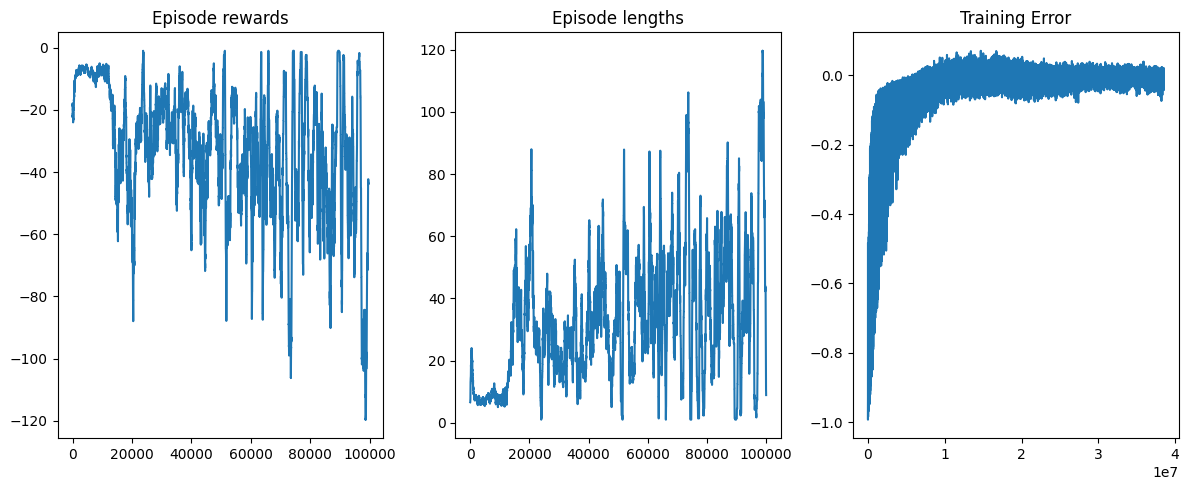

In [42]:
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))

axs[0].set_title("Episode rewards")
# compute and assign a rolling average of the data to provide a smoother graph
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)

axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)

axs[2].set_title("Training Error")
training_error_moving_average = (
    np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same")
    / rolling_length
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)

plt.tight_layout()
plt.show()

In [43]:
env.close()

**Save Q-vales in a file to save the learning process:**

In [44]:
with open('q_table.pkl', 'wb') as f:
    pickle.dump(agent.q_values, f)

**Source for Q-Learning implemetation:** 

https://gymnasium.farama.org/tutorials/training_agents/blackjack_tutorial/#sphx-glr-tutorials-training-agents-blackjack-tutorial-py (02-06-2024)


**Questions:**

*1. What is reinforcement learning?*
- a machine learning technique that uses feedback to teach an agent how to behave in a given environment by having it perform actions and observe the outcomes of those actions
- the agent receives positive feedback for each action they take that goes well and negative feedback or a penalty for each action they take that goes wrong.
- difference to supervised learning: does not need labelled input/output pairs to be presented, nor sub-optimal actions to be explicitly corrected
- difference to unsupervised learning: final goal is known

*2. What are the areas of Q-learning?*
- Q-learning can identify an optimal action-selection policy for any given finite Markov decision process
- can be used in: Playing Games, Automation, Driverless Automobiles, Finance(Algorithmic Trading), Recommendations Systems, Space Travel(Satellite Control), ...

*3. What process is called a Markov decision-making process?*
- a mathematical model for the description of decision problems
- the result is partly influenced by chance and partly by decision-making
- a Markov decision process is a 4-tuple (S, A, Pa, Ra)
- maximizes an expected future reward

*4. What is the difference between Markov decision-making and Q-learning? application*
- MDPs provide the formal framework for modelling decision problems
- Q-Learning uses the Bellman equation (based on MDP!) to iteratively update the Q-values
- Q-learning is model-free (it does not require knowledge of transition probabilities and reward functions, like Value Iteration and Policy Iteration)
- learns the Q-values through repeated interaction with the environment

*5. The concept of reward. Immediate and delayed rewards.*
- immediate rewards: provide instant feedback on the quality of an action
- delayed rewards: reflect the long-term benefits of an action and require the agent to learn to plan and optimise over longer periods of time
- Q-learning: through interactions with the environment and the receipt of rewards or penalties, the Q-table is dynamically updated

*6. What conditions must be met by the learning rate ɑ in the Q-learning algorithm?*
- the learning rate weights the relevance of the new value in contrast to the current value (how new information updates the existing Q-values)
- it should be: between 0 and 1
- it needs to: diminish over time

*7. Explain the essence of the parameter Ɣ in the Q-learning algorithm*
- Ɣ(>0 and <=1)
- the discount factor Ɣ determines the importance of future rewards relative to immediate rewards
- future rewards are less valuable than current rewards so they must be discounted

*8. What is the ϵ-greedy learning strategy? Why should it be used?*
- ϵ-greedy is a method used in reinforcement learning to balance exploration and exploitation when selecting actions
- if it were not for ϵ-greedy, the agent would not explore the possible actions; instead, it would always choose the action that was already attempted for a given state

*9. Continuous and discrete spaces of actions and states. Explain the terms and the difference.*
- a state / action space is considered discrete if the set of possible states is countable and often finite (can be represented as enumerations or lists)
- a state / action space is continuous if the set of possible states is uncountably infinite (represented by continuous variables)

*10. Why should we use discretization of action and state spaces?*
- it reduces the complexity of the problem, making the implementation easier and the learning process much more efficient
- often the exact data is not needed and continous data can be 'grouped' into discrete data points
